# Data Modelling
In which we try an assorment of models to get a feel for what works and what does not. 

## Experimental Setup
Necessary tasks to prevent repetition when investigating candidate models for this task.

### Load Training Data and Split into Inputs and Labels

In [1]:
import pandas as pd
from sklearn.externals import joblib

data = pd.read_csv('data/housing_train.csv')
X = data.drop(['median_house_value'], axis=1)
y = data['median_house_value']

X.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,-122.29,37.81,49.0,844.0,204.0,560.0,152.0,1.7500,NEAR BAY
1,-123.52,41.01,17.0,1564.0,345.0,517.0,222.0,2.1542,INLAND
2,-122.89,40.76,14.0,712.0,131.0,270.0,90.0,2.3958,INLAND
3,-118.36,34.26,34.0,3677.0,573.0,1598.0,568.0,6.8380,<1H OCEAN
4,-121.48,38.57,38.0,2809.0,805.0,1243.0,785.0,1.8512,INLAND


### Load Data Preparation Pipeline and Transform Training Data

In [2]:
prep_pipeline = joblib.load('models/data_prep_pipeline.pkl')
X_features = prep_pipeline.transform(X)

X_features

array([[ 0.20517928,  0.56004251,  0.94117647, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.08266932,  0.90010627,  0.31372549, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.14541833,  0.87353879,  0.25490196, ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.25498008,  0.47715197,  0.33333333, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.21115538,  0.77789586,  0.39215686, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.72410359,  0.02019129,  0.68627451, ...,  0.        ,
         0.        ,  1.        ]])

### Define Test Metrics
As this is a regression task, we will focus on the Root-Mean-Squared-Error and other flavours.

In [22]:
import numpy as np
from sklearn.metrics import mean_squared_error

def rmse(model_fit, features, labels):
    predictions = model_fit.predict(features)
    rmse = np.sqrt(mean_squared_error(labels, predictions))
    print('In-sample RMSE = {}'.format(rmse))
    return None

### Define Cross-Validation Experiment
The 'experiment' that we will use to test candidate models with.

In [24]:
from sklearn.cross_validation import cross_val_score

def cv_results(model_fit, features, labels):
    scores = cross_val_score(model_fit, features, labels, scoring='neg_mean_squared_error', cv=10)
    cv_mean_rmse = np.sqrt(-scores).mean()
    cv_std_rmse = np.sqrt(-scores).std()
    print('Cross-Val RMSE = {} +/- {}'.format(cv_mean_rmse, cv_std_rmse))
    return None

## Candidate Model Evaluation
Using the common evaluation metric (RMSE) defined above, we evaluation the performance of various models that are capable of addressing a regression task.

### Linear Regression
The canonical version that is (probably) implemented using matrix inversion techniques.

In [57]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_features, y)

rmse(lin_reg, X_features, y)
cv_results(lin_reg, X_features, y)

In-sample RMSE = 68525.22385943122
Cross-Val RMSE = 68636.4606586912 +/- 1323.1915166845988


### Regression Tree

In [59]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_features, y)

rmse(tree_reg, X_features, y)
cv_results(tree_reg, X_features, y)

In-sample RMSE = 0.0
Cross-Val RMSE = 68596.48672134196 +/- 2761.311911730475


### Random Forest Regressor

In [58]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(X_features, y)

rmse(forest_reg, X_features, y)
cv_results(forest_reg, X_features, y)

In-sample RMSE = 22299.189651936875
Cross-Val RMSE = 51273.953092236516 +/- 2148.2852077985426


## Optimise Chosen Model Fit
At a very high-level at it looks as if the Random Forest Regressor has the best performance out-of-the-box. Based on this, we will use grid-search to find the most optimal set of parameters to use for the final 'production' model.

In [61]:
from sklearn.model_selection import GridSearchCV

forest_reg_param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]

forest_reg_grid = GridSearchCV(forest_reg, forest_reg_param_grid, cv=5, scoring='neg_mean_squared_error')
forest_reg_grid.fit(X_features, y)

print('best parameters on grid: {}'.format(forest_reg_grid.best_params_))
print('\nFULL RESULTS:')
forest_reg_grid_res = forest_reg_grid.cv_results_
for mean_score, params in zip(forest_reg_grid_res['mean_test_score'], forest_reg_grid_res['params']):
    print(np.sqrt(-mean_score), params)

best parameters on grid: {'max_features': 6, 'n_estimators': 30}

FULL RESULTS:
64245.1491995 {'max_features': 2, 'n_estimators': 3}
55641.1061323 {'max_features': 2, 'n_estimators': 10}
52639.8384871 {'max_features': 2, 'n_estimators': 30}
59919.6042567 {'max_features': 4, 'n_estimators': 3}
52864.6550128 {'max_features': 4, 'n_estimators': 10}
50670.819093 {'max_features': 4, 'n_estimators': 30}
58390.5032013 {'max_features': 6, 'n_estimators': 3}
52226.2335986 {'max_features': 6, 'n_estimators': 10}
50161.579814 {'max_features': 6, 'n_estimators': 30}
58269.1353199 {'max_features': 8, 'n_estimators': 3}
51939.2037379 {'max_features': 8, 'n_estimators': 10}
50201.9518547 {'max_features': 8, 'n_estimators': 30}
61769.244758 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54069.8756953 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59570.473392 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
51979.2750891 {'bootstrap': False, 'max_features': 3, 'n_est

### Persist the Best Fit
Defending against the situation where we have to re-run this notebook to continue with the model analysis below.

In [63]:
from sklearn.externals import joblib

forest_reg_opt = forest_reg_grid.best_estimator_
joblib.dump(forest_reg_grid.best_estimator_, 'models/forest_reg_opt.pkl') 

['models/forest_reg_opt.pkl']

## Model Analysis
Having chosen a category of regression model and optimised it to the best of our abilities (given time and resource constraints), we now analyse the model we intend for production deployment.

### Load Persisted Model
Use the saved model as a verification of the mode serialisation

In [10]:
forest_reg_opt = joblib.load('models/forest_reg_opt.pkl')

### Extract Feature Names from Pipeline
Define a helper-functions to make model and pipeline analysis easier.

In [5]:
def get_pipline_union_contents(union_pl):
    for pl in union_pl.transformer_list:
        for tf in pl[1].named_steps:
            print('{} : {}'.format(pl[0], tf))
    return None

def get_transformer(union_pl, nested_pl_name, trans_name):
    pipeline = [p[1] for p in union_pl.transformer_list if p[0] == nested_pl_name]
    transformer = pipeline[0].named_steps[trans_name]
    return transformer

def get_feature_names(union_pl, nested_pl_name, trans_name):
    transformer = get_transformer(union_pl, nested_pl_name, trans_name)
    return transformer.get_feature_names()

Examine the contents of our unified pipeline.

In [9]:
get_pipline_union_contents(prep_pipeline)

numeric_pipeline : var_selector
numeric_pipeline : imputer
numeric_pipeline : scaler
categorical_pipeline : var_selector
categorical_pipeline : categorical_encoder


Extract the feature names from the appropriate transformers.

In [8]:
num_feature_names = get_feature_names(prep_pipeline, 'numeric_pipeline', 'var_selector')
cat_feature_names = get_feature_names(prep_pipeline, 'categorical_pipeline', 'categorical_encoder')
feature_names = num_feature_names + cat_feature_names

feature_names

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 '<1H OCEAN',
 'INLAND',
 'ISLAND',
 'NEAR BAY',
 'NEAR OCEAN']

### Variable Importance
This is an output that is specific to tree-based models.

In [17]:
for feature, importance in sorted(zip(forest_reg_opt.feature_importances_, feature_names), reverse=True):
    print('{} : {}'.format(importance, feature))

median_income : 0.40378914164056806
INLAND : 0.13848740045967717
longitude : 0.12608777591811535
latitude : 0.11814654506307729
housing_median_age : 0.0492016418925097
population : 0.04136942662500728
total_rooms : 0.03699749581003033
total_bedrooms : 0.030695729783407597
households : 0.029043604797191574
<1H OCEAN : 0.014689376795851255
NEAR OCEAN : 0.008772263614444884
NEAR BAY : 0.002410766043044271
ISLAND : 0.00030883155707509485


From which we can see that `median_income` is the most important factor that could be attributed to `median_house_value`.

### Apply Model to Test Data
Crunch time! Load the data that we have left untouched until now - mimicking what one might expect when a model is out 'in the wild' - and see how the model performs.

In [35]:
test_data = pd.read_csv('data/housing_test.csv')
X_test = test_data.drop(['median_house_value'], axis=1)
y_test = test_data['median_house_value'].values

X_test.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,-118.19,33.99,36.0,1273.0,379.0,1398.0,353.0,2.4516,<1H OCEAN
1,-118.28,34.09,49.0,3828.0,1197.0,2862.0,1009.0,2.4677,<1H OCEAN
2,-121.07,38.66,22.0,1831.0,274.0,813.0,269.0,4.6394,INLAND
3,-117.98,33.75,37.0,1264.0,274.0,783.0,273.0,3.3438,<1H OCEAN
4,-121.79,36.68,22.0,6912.0,1513.0,3794.0,1455.0,3.0608,<1H OCEAN


In [36]:
X_test_features = prep_pipeline.transform(X_test)
rmse(forest_reg_opt, X_test_features, y_test)

In-sample RMSE = 47593.25825632105


This is better than the RMSE that we observed in our initia CV experiment! Now, we take a closer look at where the model performed well and where it did not.

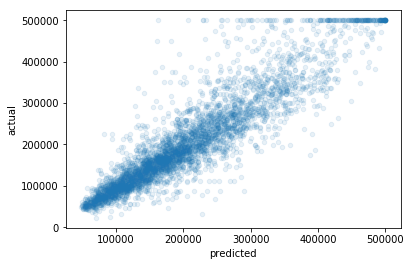

In [66]:
%matplotlib inline

predicted = forest_reg_opt.predict(X_test_features)
abs_error = np.absolute(predicted - y_test)

model_performance = pd.DataFrame(
    np.concatenate([predicted.reshape((-1, 1)), y_test.reshape((-1, 1)), abs_error.reshape((-1, 1))], axis=1), 
    columns=['predicted', 'actual', 'abs_error']
)

model_performance.plot(kind='scatter', x='predicted', y='actual', alpha=0.1)

### Brief Conclusions
It is pretty clear that a lot of the error is coming from observed data points that appear to have been capped at 500,000. If we can correct for this, then we may end up with a model that really is good enough to put into production!